# Capstone Two - 5 Extended Modeling: PROPHET<a id='5'></a>

## 5.1 Contents<a id='5.1'></a>
* [5 Extended Modeling](#5)
  * [5.1 Contents](#5.1)
  * [5.2 Imports](#5.2)
  * [5.3 Load The Data](#5.3)
  * [5.4 Data Processing](#5.4)
  * [5.5 Modeling](#5.5)
    * [5.5.1 Apply Prophet() for single timeseries](#5.5.1)
    * [5.5.2 Apply Prophet() for multiple timeseries](#5.5.2)
  * [5.6 Evaluation](#5.6)
    * [5.6.1 MAPE](#5.6.1)
    * [5.6.2 Scatter plots](#5.6.2)
    * [5.6.3 Distribution of residuals](#5.6.3)
  * [5.7 Save Data](#5.7) 

## 5.2 Imports<a id='5.2'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from library.sb_utils import save_file

In [2]:
from prophet import Prophet

## 5.3 Load The Data<a id='5.3'></a>

In [3]:
data_dir = '../data/'

data_ori = pd.read_csv(data_dir+'train_all_groups.csv')
data_ori.head(3)

,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,transactions,holiday_type,transferred,year,month
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,False,2013,1
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,False,2013,1
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,False,2013,1


In [4]:
data = data_ori[['date', 'store_nbr', 'family', 'sales']]
data.set_index('date', inplace = True)
data.head(3)

,store_nbr,family,sales
date,,,
2013-01-01,1,AUTOMOTIVE,0.0
2013-01-01,1,BABY CARE,0.0
2013-01-01,1,BEAUTY,0.0


## 5.4 Data Processing<a id='5.4'></a>

In [5]:
stores = data['store_nbr'].unique()
families = data['family'].unique()

print(stores)
print(families)
print(len(stores), len(families))

[ 1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52
 53 54  6  7  8  9]
['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']
54 33


In [6]:
grp = data.groupby(['store_nbr', 'family'])

df = pd.DataFrame()

for s in stores:
    for f in families:
        grp_sel = grp.get_group((s, f))
        col_name = str(s)+","+f
        df_temp = pd.DataFrame(grp_sel['sales']).rename(columns={'sales': col_name})
        df = pd.concat([df, df_temp], axis=1)

df.head(3)

,"1,AUTOMOTIVE","1,BABY CARE","1,BEAUTY","1,BEVERAGES","1,BOOKS","1,BREAD/BAKERY","1,CELEBRATION","1,CLEANING","1,DAIRY","1,DELI",...,"9,MAGAZINES","9,MEATS","9,PERSONAL CARE","9,PET SUPPLIES","9,PLAYERS AND ELECTRONICS","9,POULTRY","9,PREPARED FOODS","9,PRODUCE","9,SCHOOL AND OFFICE SUPPLIES","9,SEAFOOD"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,...,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000
2013-01-02,2.0,0.0,2.0,1091.0,0.0,470.652,0.0,1060.0,579.0,164.069,...,0.0,374.531,482.0,0.0,0.0,651.292,83.0,0.0,0.0,29.214
2013-01-03,3.0,0.0,0.0,919.0,0.0,310.655,0.0,836.0,453.0,151.582,...,0.0,400.863,372.0,0.0,0.0,509.496,66.0,0.0,0.0,25.000


Totally 54*33 = 1782 time series.

In [7]:
# convert datetime index to period
df.index = pd.DatetimeIndex(df.index).to_period('D')

In [8]:
# Fill time gaps on Christmas every year
df = df.resample('1D').mean().ffill()#interpolate() # forward fill or interpolate didn't affect the mAPE result

In [9]:
# Sales are zeros on New Year's Day (Store Closed)
df.loc[['2014-01-01']] = df.loc[['2013-12-31']].values
df.loc[['2015-01-01']] = df.loc[['2014-12-31']].values
df.loc[['2016-01-01']] = df.loc[['2015-12-31']].values
df.loc[['2017-01-01']] = df.loc[['2016-12-31']].values

In [10]:
df = df.to_timestamp(freq='D') # type from period to datetime

In [11]:
# train-test split: the last 16 days as testing set
n_train = len(df)-16
df_train = df[7:n_train] #starting from day 8
df_test = df[n_train:]

## 5.5 Modeling<a id='5.5'></a>

### 5.5.1 Apply Prophet() for single timeseries<a id='5.5.1'></a>

Try Prophet() using the time series in the first column.

In [12]:
y1_train = df_train["1,AUTOMOTIVE"] # first column
y1_test = df_test["1,AUTOMOTIVE"]

y1_train = y1_train.reset_index() # Prophet() needs the date as a column
y1_test = y1_test.reset_index()

y1_train.columns = ['ds','y']
y1_test.columns = ['ds','y']

In [13]:
model = Prophet()
model.fit(y1_train)

10:35:17 - cmdstanpy - INFO - Chain [1] start processing
10:35:17 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
y1_pred = model.predict(y1_test)  # predict N steps into the future
y1_pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(3)

,ds,yhat,yhat_lower,yhat_upper
0,2017-07-31,4.705152,1.204213,7.760568
1,2017-08-01,5.275146,2.147799,8.607314
2,2017-08-02,4.893452,1.653164,8.171703


In [15]:
# APE = ABS((actual - predicted) / actual)
APE_y1 = abs( (y1_test['y'] - y1_pred['yhat']) / y1_test['y'])

# MEAN(APE)
mAPE_y1 = np.mean(APE_y1)
print('MAPE: '+str(mAPE_y1))

MAPE: 0.75584475388413


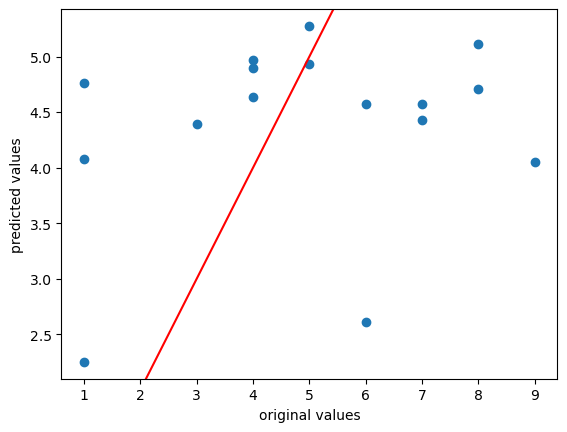

In [16]:
# predicted-vs-actual scatterplot
fig, ax = plt.subplots()
ax.scatter(y1_test['y'], y1_pred['yhat'])
plt.xlabel("original values")
plt.ylabel("predicted values")
ax.axline((3,3), slope=1, color = 'red')
plt.show()

We can see the mean APE is quite large, and the scatter plot also shows poor prediction results. The Prophet model may not be a good model for this specific time series, and we'll try to use Prophet() for some other time series. 

### 5.5.2 Apply Prophet() for multiple timeseries<a id='5.5.2'></a>

In [17]:
stores1 = [*range(1, 7, 1)] # No.1-6 stores
families1 = ['BREAD/BAKERY', 'DAIRY', 'GROCERY I']

grp = data.groupby(['store_nbr', 'family'])

df0 = pd.DataFrame()

for s in stores1:
    for f in families1:
        grp_sel = grp.get_group((s, f))
        col_name = str(s)+","+f
        df_temp = pd.DataFrame(grp_sel['sales']).rename(columns={'sales': col_name})
        df0 = pd.concat([df0, df_temp], axis=1)

df0.head(3)

,"1,BREAD/BAKERY","1,DAIRY","1,GROCERY I","2,BREAD/BAKERY","2,DAIRY","2,GROCERY I","3,BREAD/BAKERY","3,DAIRY","3,GROCERY I","4,BREAD/BAKERY","4,DAIRY","4,GROCERY I","5,BREAD/BAKERY","5,DAIRY","5,GROCERY I","6,BREAD/BAKERY","6,DAIRY","6,GROCERY I"
date,,,,,,,,,,,,,,,,,,
2013-01-01,0.000,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0
2013-01-02,470.652,579.0,2652.0,523.882,651.0,3870.0,1361.636,1606.0,8463.0,422.537,589.0,4087.0,566.917,414.0,4558.0,689.217,683.0,5535.0
2013-01-03,310.655,453.0,2121.0,321.693,461.0,2640.0,886.184,1377.0,6712.0,273.752,431.0,2824.0,377.887,366.0,3260.0,412.324,542.0,4040.0


In [18]:
df0.index = pd.DatetimeIndex(df0.index).to_period('D')
df0 = df0.resample('1D').mean().ffill()#interpolate()

In [19]:
df0.loc[['2014-01-01']] = df0.loc[['2013-12-31']].values
df0.loc[['2015-01-01']] = df0.loc[['2014-12-31']].values
df0.loc[['2016-01-01']] = df0.loc[['2015-12-31']].values
df0.loc[['2017-01-01']] = df0.loc[['2016-12-31']].values

In [20]:
df0 = df0.to_timestamp(freq='D') # type from period to datetime

In [21]:
# Train-Test Split
df1_train = df0[7:n_train] #starting from day 8
df1_test = df0[n_train:]

In [22]:
# N = len(df1.columns)
mAPE = []
df_pred = pd.DataFrame()
df_actual = pd.DataFrame()

for group in df0.columns:
    y_train = df1_train[group]
    y_test = df1_test[group]
    
    y_train = y_train.reset_index() # Prophet() needs the "date" as a column
    y_test = y_test.reset_index()
    
    y_train.columns = ['ds','y']
    y_test.columns = ['ds','y']
    
    model = Prophet().fit(y_train)
    
    y_pred = model.predict(y_test)
    
    APE_y = abs( (y_test['y'] - y_pred['yhat']) / y_test['y'])
    mAPE_y = np.mean(APE_y)
    print(group+' MAPE: '+str(mAPE_y))
    
    mAPE.append(mAPE_y)
    df_pred[group] = y_pred['yhat']
    df_actual[group] = y_test['y']


10:35:18 - cmdstanpy - INFO - Chain [1] start processing
10:35:18 - cmdstanpy - INFO - Chain [1] done processing
10:35:18 - cmdstanpy - INFO - Chain [1] start processing
10:35:18 - cmdstanpy - INFO - Chain [1] done processing


1,BREAD/BAKERY MAPE: 0.21747281803135288


10:35:18 - cmdstanpy - INFO - Chain [1] start processing
10:35:18 - cmdstanpy - INFO - Chain [1] done processing


1,DAIRY MAPE: 0.17968026631127557


10:35:18 - cmdstanpy - INFO - Chain [1] start processing


1,GROCERY I MAPE: 0.2182684978824601


10:35:19 - cmdstanpy - INFO - Chain [1] done processing
10:35:19 - cmdstanpy - INFO - Chain [1] start processing


2,BREAD/BAKERY MAPE: 0.1109577496634915


10:35:19 - cmdstanpy - INFO - Chain [1] done processing
10:35:19 - cmdstanpy - INFO - Chain [1] start processing
10:35:19 - cmdstanpy - INFO - Chain [1] done processing


2,DAIRY MAPE: 0.11200764266639877
2,GROCERY I MAPE: 0.12214112131314822


10:35:19 - cmdstanpy - INFO - Chain [1] start processing
10:35:19 - cmdstanpy - INFO - Chain [1] done processing
10:35:19 - cmdstanpy - INFO - Chain [1] start processing
10:35:19 - cmdstanpy - INFO - Chain [1] done processing


3,BREAD/BAKERY MAPE: 0.09012809820223644
3,DAIRY MAPE: 0.0796038291576715


10:35:20 - cmdstanpy - INFO - Chain [1] start processing
10:35:20 - cmdstanpy - INFO - Chain [1] done processing
10:35:20 - cmdstanpy - INFO - Chain [1] start processing


3,GROCERY I MAPE: 0.1335519041177018


10:35:20 - cmdstanpy - INFO - Chain [1] done processing
10:35:20 - cmdstanpy - INFO - Chain [1] start processing


4,BREAD/BAKERY MAPE: 0.20967049918295066


10:35:20 - cmdstanpy - INFO - Chain [1] done processing
10:35:20 - cmdstanpy - INFO - Chain [1] start processing
10:35:20 - cmdstanpy - INFO - Chain [1] done processing


4,DAIRY MAPE: 0.1178158110205845


10:35:20 - cmdstanpy - INFO - Chain [1] start processing
10:35:21 - cmdstanpy - INFO - Chain [1] done processing


4,GROCERY I MAPE: 0.1871411834210932


10:35:21 - cmdstanpy - INFO - Chain [1] start processing


5,BREAD/BAKERY MAPE: 0.1027212199369201


10:35:21 - cmdstanpy - INFO - Chain [1] done processing
10:35:21 - cmdstanpy - INFO - Chain [1] start processing
10:35:21 - cmdstanpy - INFO - Chain [1] done processing


5,DAIRY MAPE: 0.07847948012602116


10:35:21 - cmdstanpy - INFO - Chain [1] start processing
10:35:21 - cmdstanpy - INFO - Chain [1] done processing


5,GROCERY I MAPE: 0.09944426732804042


10:35:21 - cmdstanpy - INFO - Chain [1] start processing


6,BREAD/BAKERY MAPE: 0.13366613475715258


10:35:22 - cmdstanpy - INFO - Chain [1] done processing
10:35:22 - cmdstanpy - INFO - Chain [1] start processing
10:35:22 - cmdstanpy - INFO - Chain [1] done processing


6,DAIRY MAPE: 0.106613041500985
6,GROCERY I MAPE: 0.11783052621314455


## 5.6 Evaluation<a id='5.6'></a>

### 5.6.1 MAPE<a id='5.6.1'></a>

In [23]:
df_mape = pd.DataFrame()
df_mape['Group'] = df0.columns#[0:18]
df_mape['MAPE'] = mAPE

print("\033[1m"+"Sorted MAPE values:")
df_mape.sort_values(by=['MAPE'])

Sorted MAPE values:


,Group,MAPE
13,"5,DAIRY",0.078479
7,"3,DAIRY",0.079604
6,"3,BREAD/BAKERY",0.090128
14,"5,GROCERY I",0.099444
12,"5,BREAD/BAKERY",0.102721
16,"6,DAIRY",0.106613
3,"2,BREAD/BAKERY",0.110958
4,"2,DAIRY",0.112008
10,"4,DAIRY",0.117816
17,"6,GROCERY I",0.117831


In [24]:
print("\033[1m"+"Best 3 MAPE:")
df_best = df_mape.nsmallest(3, 'MAPE')
df_best

Best 3 MAPE:


,Group,MAPE
13,"5,DAIRY",0.078479
7,"3,DAIRY",0.079604
6,"3,BREAD/BAKERY",0.090128


In [25]:
print("\033[1m"+"Worst 3 MAPE:")
df_worst = df_mape.nlargest(3, 'MAPE')
df_worst

Worst 3 MAPE:


,Group,MAPE
2,"1,GROCERY I",0.218268
0,"1,BREAD/BAKERY",0.217473
9,"4,BREAD/BAKERY",0.209670


**The Best MAPE is about 8%, and the Worst MAPE is about 22%.**

### 5.6.2 Scatter plots<a id='5.6.2'></a>

In [26]:
def scatterplots(columns, ncol=None, figsize=(8, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.25, hspace=0.4)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = df_actual[col], y = df_pred[col], alpha=0.8)
        ax.set(xlabel="Aactual values", ylabel="Predicted values", title=col)
        min_val = min(df_actual[col])
        ax.axline((min_val, min_val), slope=1, color = 'red')    
    nsubplots = nrow * ncol    
    # for empty in range(i+1, nsubplots):
    #     axes.flatten()[empty].set_visible(False)

Upper: Best 3, Lower: Worst 3


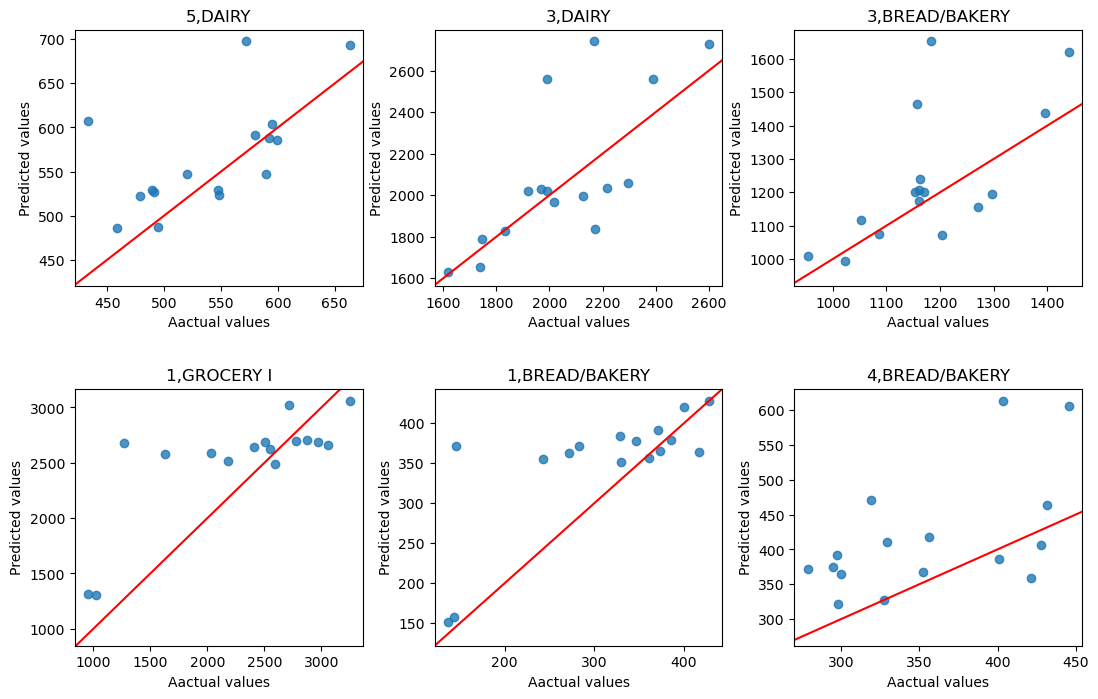

In [27]:
df_comb = pd.concat([df_best, df_worst])
features = df_comb.Group
print("\033[1m"+"Upper: Best 3, Lower: Worst 3")
scatterplots(features, ncol=3, figsize=(13, 8))

**The scatter points in the upper Best 3 plots are closer to the y=x line than those in the lower 3 plots.**

### 5.6.3 Distribution of residuals<a id='5.6.3'></a>

In [28]:
# Residuals
df_resid = df_actual - df_pred
# PEs
df_pe = (df_actual - df_pred) / df_actual

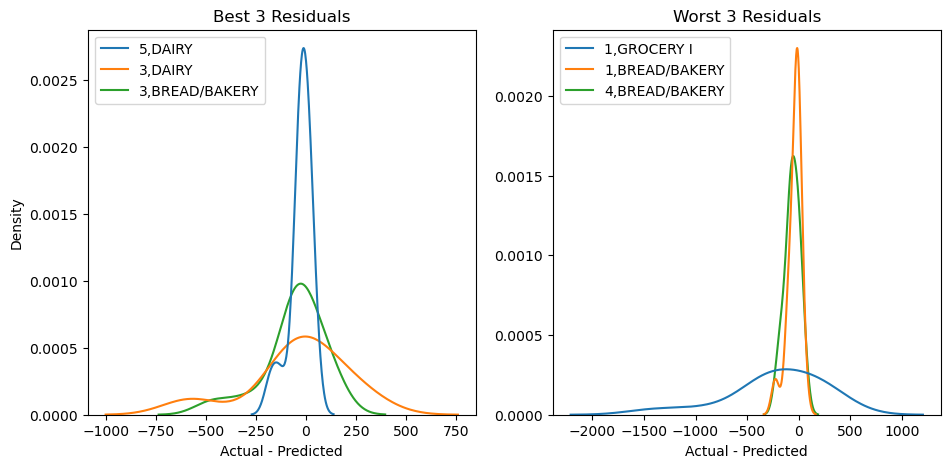

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5))
sns.kdeplot(ax=axes[0], data=df_resid[df_best.Group])
axes[0].set_title("Best 3 Residuals")
axes[0].set_xlabel("Actual - Predicted")
sns.kdeplot(ax=axes[1], data=df_resid[df_worst.Group])
axes[1].set_title("Worst 3 Residuals")
axes[1].set_xlabel("Actual - Predicted")
axes[1].set_ylabel("")
plt.show()

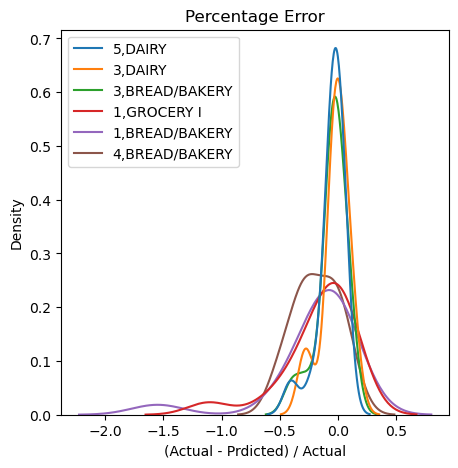

In [30]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.kdeplot(data=df_pe[df_comb.Group])
plt.title("Percentage Error")
plt.xlabel("(Actual - Prdicted) / Actual")
plt.show()

**From the Distribution of Residuals plots, we cannot figure out how the "Best 3" is better than the "Worst 3".\
From the Percentage Error plot, we can clear see that the center lines of the "Best 3" are closer to zero and their distributions are also more concentrated.**

## 5.7 Save Data<a id='5.7'></a>

In [31]:
datapath = '../data'
save_file(df_actual, 'df_actual.csv', datapath)
save_file(df_pred, 'df_pred_2.csv', datapath)
save_file(df_mape, 'df_mape_2.csv', datapath)

Writing file.  "../data/df_actual.csv"
Writing file.  "../data/df_pred_2.csv"
Writing file.  "../data/df_mape_2.csv"
